In [24]:
import pandas as pd
import numpy as np
from keras.src.layers import GRU, Dropout, Dense
from keras.src.optimizers import Adam
from keras import Sequential, Input
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from matplotlib import pyplot as plt

In [25]:
df_1 = pd.read_csv("../data/processed/production_cross_data.csv")
df_2 = pd.read_csv("../data/processed/production_fossil_data.csv")
df_3 = pd.read_csv("../data/processed/production_hydro_data.csv")
df_4 = pd.read_csv("../data/processed/production_nuclear_data.csv")

dfs = [df_1, df_2, df_3, df_4]

In [26]:
df_1.head()

,date,production,temperature,humidity,precipitation,cloud_cover,wind_speed
0,2023-01-01 00:00:00,108.6,6.9,91,0.0,53,20.9
1,2023-01-01 01:00:00,84.8,6.9,92,0.0,32,20.7
2,2023-01-01 02:00:00,53.7,8.1,89,0.0,8,23.5
3,2023-01-01 03:00:00,36.3,7.6,91,0.0,6,22.1
4,2023-01-01 04:00:00,31.1,7.3,92,0.0,24,21.4


In [27]:
df_2.head()

,date,production,temperature,humidity,precipitation,cloud_cover,wind_speed
0,2023-01-01 00:00:00,36.1,6.9,91,0.0,53,20.9
1,2023-01-01 01:00:00,36.1,6.9,92,0.0,32,20.7
2,2023-01-01 02:00:00,39.6,8.1,89,0.0,8,23.5
3,2023-01-01 03:00:00,36.6,7.6,91,0.0,6,22.1
4,2023-01-01 04:00:00,35.4,7.3,92,0.0,24,21.4


In [28]:
df_3.head()

,date,production,temperature,humidity,precipitation,cloud_cover,wind_speed
0,2023-01-01 00:00:00,159.2,6.9,91,0.0,53,20.9
1,2023-01-01 01:00:00,157.9,6.9,92,0.0,32,20.7
2,2023-01-01 02:00:00,157.5,8.1,89,0.0,8,23.5
3,2023-01-01 03:00:00,157.1,7.6,91,0.0,6,22.1
4,2023-01-01 04:00:00,157.9,7.3,92,0.0,24,21.4


In [29]:
df_4.head()

,date,production,temperature,humidity,precipitation,cloud_cover,wind_speed
0,2023-01-01 00:00:00,698.5,6.9,91,0.0,53,20.9
1,2023-01-01 01:00:00,698.5,6.9,92,0.0,32,20.7
2,2023-01-01 02:00:00,698.5,8.1,89,0.0,8,23.5
3,2023-01-01 03:00:00,698.4,7.6,91,0.0,6,22.1
4,2023-01-01 04:00:00,698.4,7.3,92,0.0,24,21.4


In [30]:
df_1.isnull().sum()

date             0
production       0
temperature      0
humidity         0
precipitation    0
cloud_cover      0
wind_speed       0
dtype: int64

In [31]:
df_2.isnull().sum()

date             0
production       0
temperature      0
humidity         0
precipitation    0
cloud_cover      0
wind_speed       0
dtype: int64

In [32]:
df_3.isnull().sum()

date             0
production       0
temperature      0
humidity         0
precipitation    0
cloud_cover      0
wind_speed       0
dtype: int64

In [33]:
df_4.isnull().sum()

date             0
production       0
temperature      0
humidity         0
precipitation    0
cloud_cover      0
wind_speed       0
dtype: int64

In [34]:
for df in dfs:
    cols = df.columns.tolist()
    cols.remove("date")
    df[cols] = df[cols].bfill()

In [35]:
def create_time_series(data, n_past):
    X, y = [], []
    for i in range(n_past, len(data)):
            X.append(data[i - n_past:i, 0:data.shape[1]])
            y.append(data[i,0])
    return np.array(X),np.array(y)

In [36]:
def create_model(train_input_shape):
    model = Sequential(name='GRU')
    optimizer = Adam(learning_rate=0.01)
    
    model.add(Input(shape=(train_input_shape.shape[1], train_input_shape.shape[2])))
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(32))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(1))
    
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    return model

In [37]:
window_size = 24

In [38]:
def select_input_data(df):
    input_data = df.columns.tolist()
    output_data = 'production'

    input_data.remove(output_data)
    input_data.remove('date')
    return input_data, output_data

In [39]:
def mutual_regression_score(df, input_data, output_data):
    ig_scores = mutual_info_regression(df[input_data], df[output_data])

    feature_scores = pd.DataFrame({'Feature': df[input_data].columns, 'Information_Gain': ig_scores})
    feature_scores = feature_scores.sort_values(by='Information_Gain', ascending=False)

    feature_scores.reset_index(drop=True, inplace=True)
    print(feature_scores.head())
    
    return feature_scores

In [40]:
def select_features(output_data, feature_scores):
    output_data = [output_data]
    for i in feature_scores['Feature'][:3].tolist():
        output_data.append(i)
        
    input_columns = output_data
    print(df[input_columns].head())
    
    filtered_df = df[input_columns]
    dataset = filtered_df.values
    return dataset, input_columns

In [41]:
def shape_data(dataset):
    test_data_size = round(0.2 * len(dataset))

    train_data = dataset[:-test_data_size]
    test_data = dataset[-test_data_size:]

    print("Train data shape:", train_data.shape)
    print("Test data shape:", test_data.shape)
    
    return train_data, test_data, test_data_size

In [42]:
def execute_training(train_data, test_data, input_columns):
    scaler = MinMaxScaler()

    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    
    X_train, y_train = create_time_series(train_data, window_size)
    X_test, y_test = create_time_series(test_data, window_size)
    
    print("Shape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)
    
    model = create_model(X_train)
    
    hist = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)
    
    predicted = model.predict(X_test, verbose=0)
    
    predicted_copy_array = np.repeat(predicted, len(input_columns), axis=-1)
    print(predicted_copy_array.shape)
    
    pred = scaler.inverse_transform(np.reshape(predicted_copy_array,(len(predicted), len(input_columns))))[:, 0]
    actual_copy_array = np.repeat(y_test, len(input_columns), axis=-1)
    actual = scaler.inverse_transform(np.reshape(actual_copy_array,(len(y_test), len(input_columns))))[:, 0]
    
    return pred, actual, hist

In [43]:
def evaluate_model_performance(actual, pred, test_data_size, hist):
    mse = mean_squared_error(actual, pred)
    mae = mean_absolute_error(actual, pred)
    evs = explained_variance_score(actual, pred)
    
    print(f'MSE: {mse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'EVS: {evs:.2f}')
    
    dates = df['date'].values

    output_df = {
        'Date': dates[-test_data_size + window_size:],
        'True': actual,
        'Predicted': pred
    }

    output_df = pd.DataFrame(output_df)
    print(output_df.head(10))
    
    line_plot(output_df.head(50))
    loss_line_plot(hist)

In [44]:
def line_plot(plot_out_df):
    plt.figure(figsize=(12, 8))
    plt.plot(plot_out_df['Date'], plot_out_df['True'], label='True')
    plt.plot(plot_out_df['Date'], plot_out_df['Predicted'], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Production')
    plt.title('Actual vs Predicted values')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [45]:
def loss_line_plot(hist):
    plt.figure(figsize=(16, 6))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

         Feature  Information_Gain
0    temperature          0.174242
1     wind_speed          0.032346
2    cloud_cover          0.031955
3  precipitation          0.005233
4       humidity          0.000000
   production  temperature  wind_speed  cloud_cover
0       108.6          6.9        20.9           53
1        84.8          6.9        20.7           32
2        53.7          8.1        23.5            8
3        36.3          7.6        22.1            6
4        31.1          7.3        21.4           24
Train data shape: (10022, 4)
Test data shape: (2505, 4)
Shape of X_train: (9998, 24, 4)
Shape of X_test: (2481, 24, 4)
Shape of y_train: (9998,)
Shape of y_test: (2481,)
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0682 - val_loss: 0.0027
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms

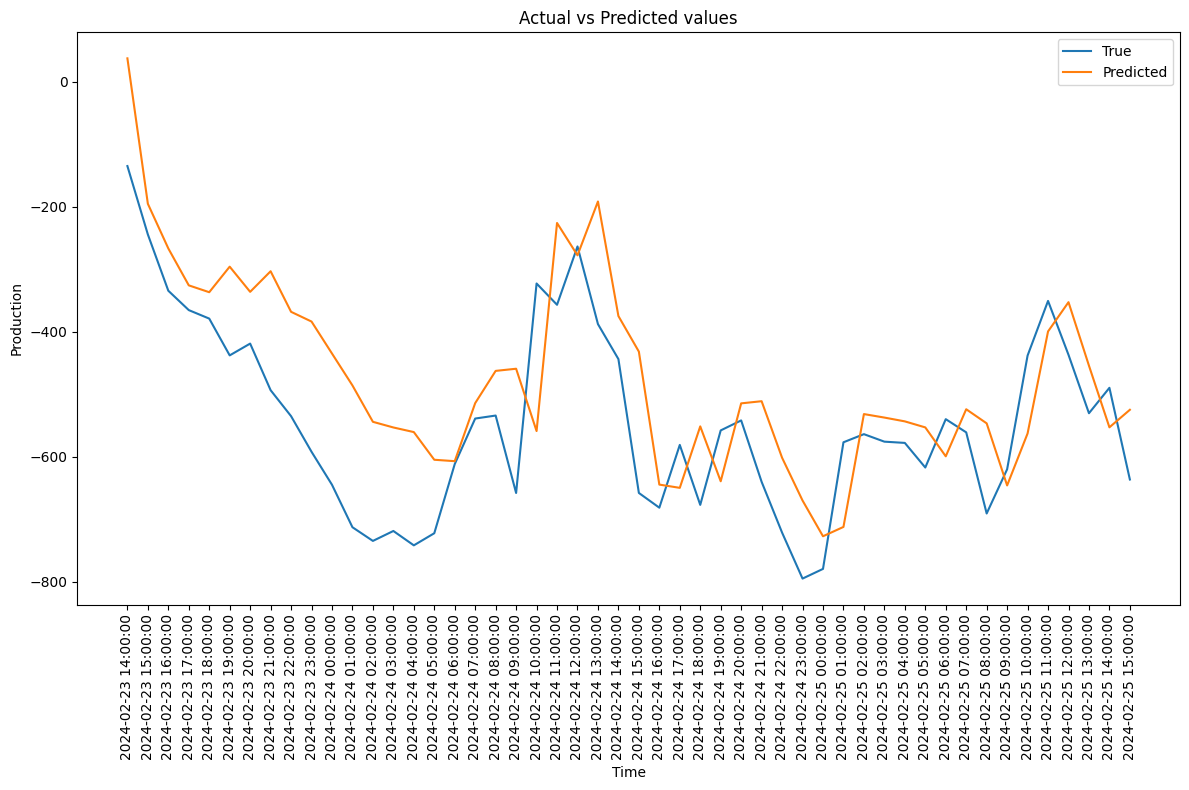

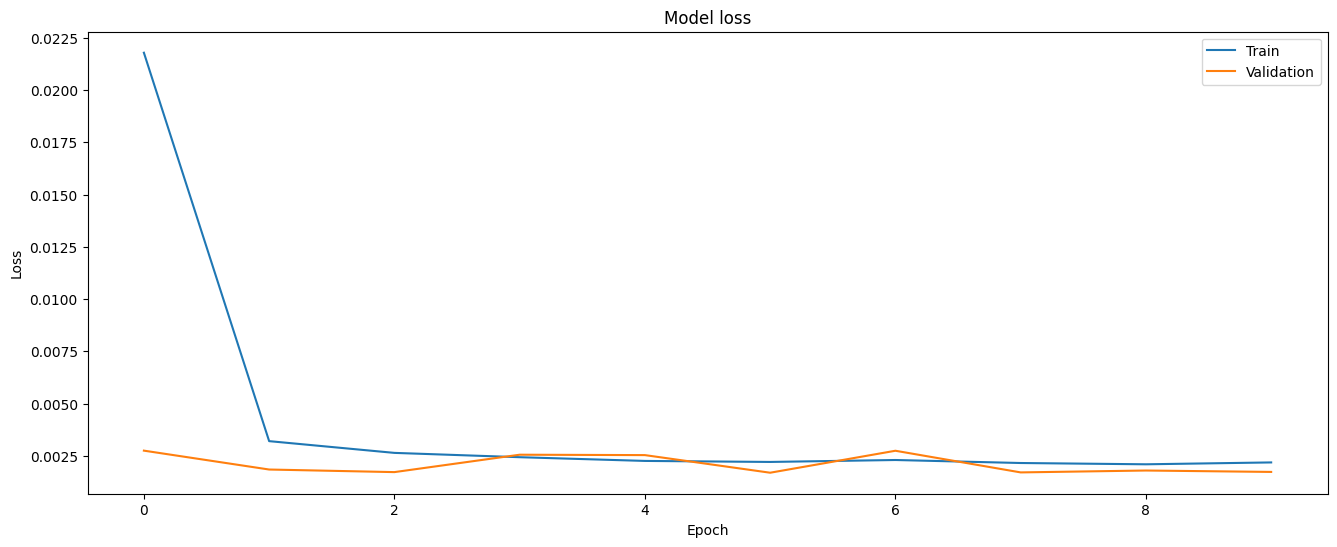

         Feature  Information_Gain
0    temperature          0.294849
1    cloud_cover          0.065967
2       humidity          0.062247
3     wind_speed          0.054829
4  precipitation          0.014190
   production  temperature  cloud_cover  humidity
0        36.1          6.9           53        91
1        36.1          6.9           32        92
2        39.6          8.1            8        89
3        36.6          7.6            6        91
4        35.4          7.3           24        92
Train data shape: (10022, 4)
Test data shape: (2505, 4)
Shape of X_train: (9998, 24, 4)
Shape of X_test: (2481, 24, 4)
Shape of y_train: (9998,)
Shape of y_test: (2481,)
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0460 - val_loss: 0.0041
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss

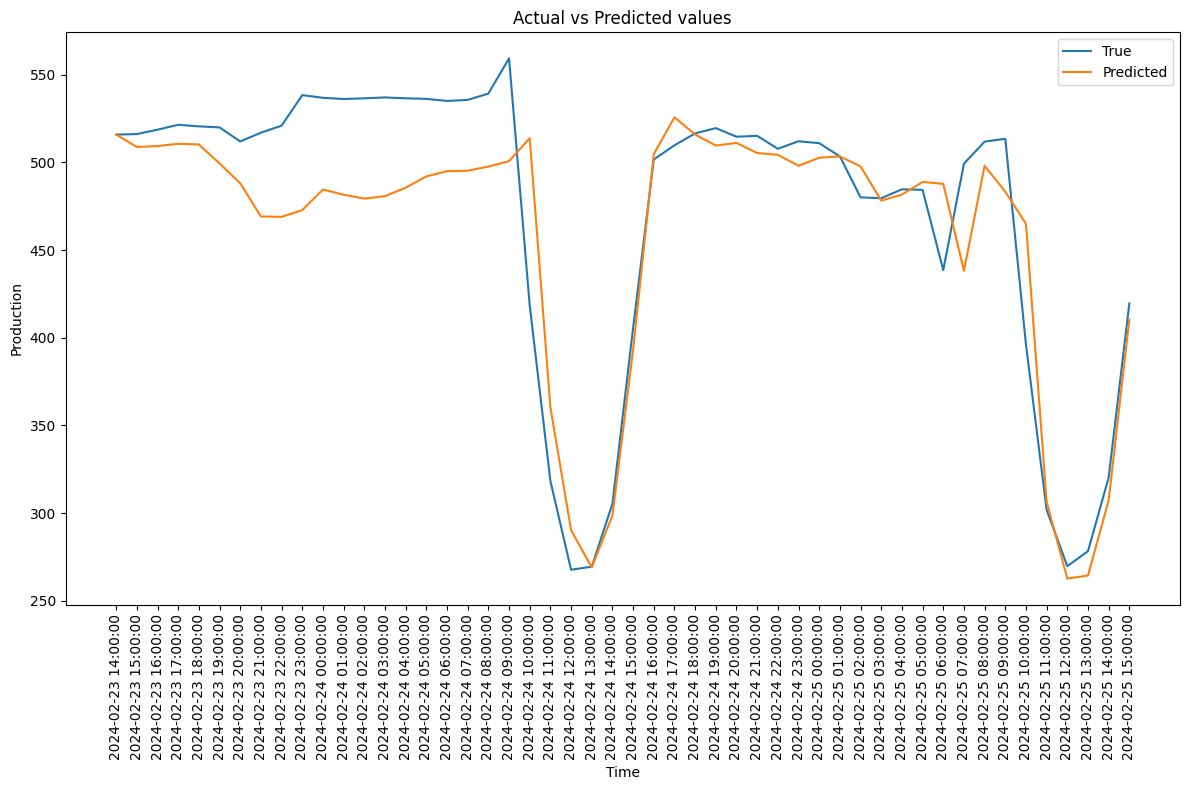

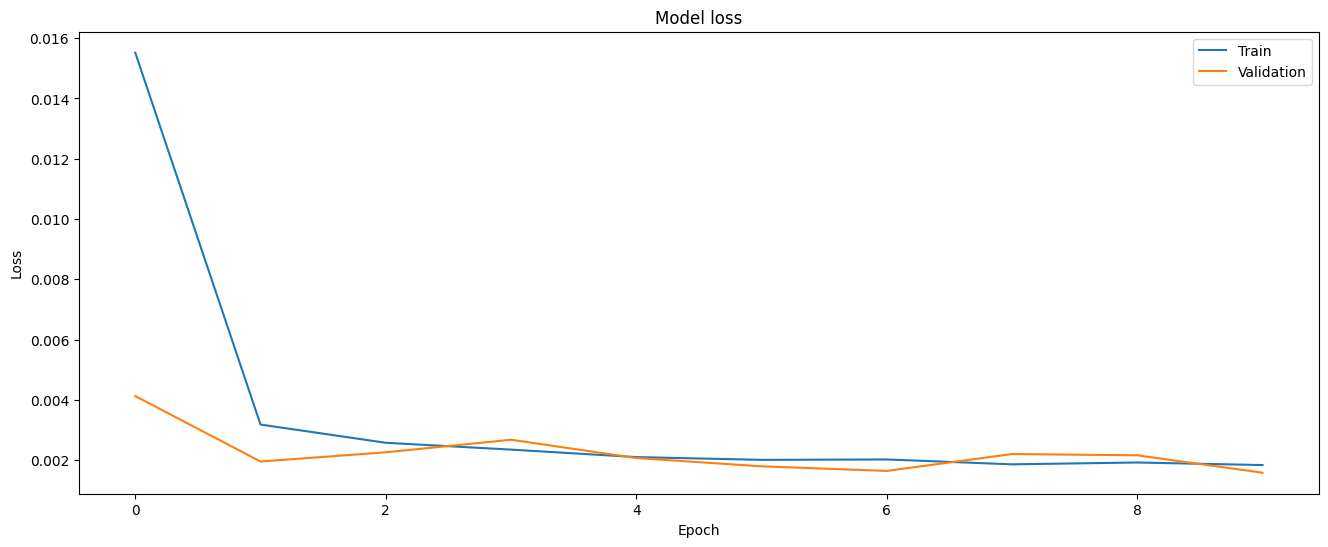

         Feature  Information_Gain
0    temperature          0.117957
1       humidity          0.039068
2     wind_speed          0.020644
3  precipitation          0.010280
4    cloud_cover          0.009366
   production  temperature  humidity  wind_speed
0       159.2          6.9        91        20.9
1       157.9          6.9        92        20.7
2       157.5          8.1        89        23.5
3       157.1          7.6        91        22.1
4       157.9          7.3        92        21.4
Train data shape: (10022, 4)
Test data shape: (2505, 4)
Shape of X_train: (9998, 24, 4)
Shape of X_test: (2481, 24, 4)
Shape of y_train: (9998,)
Shape of y_test: (2481,)
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.1427 - val_loss: 0.0037
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0060 - val_loss: 0.0033
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.00

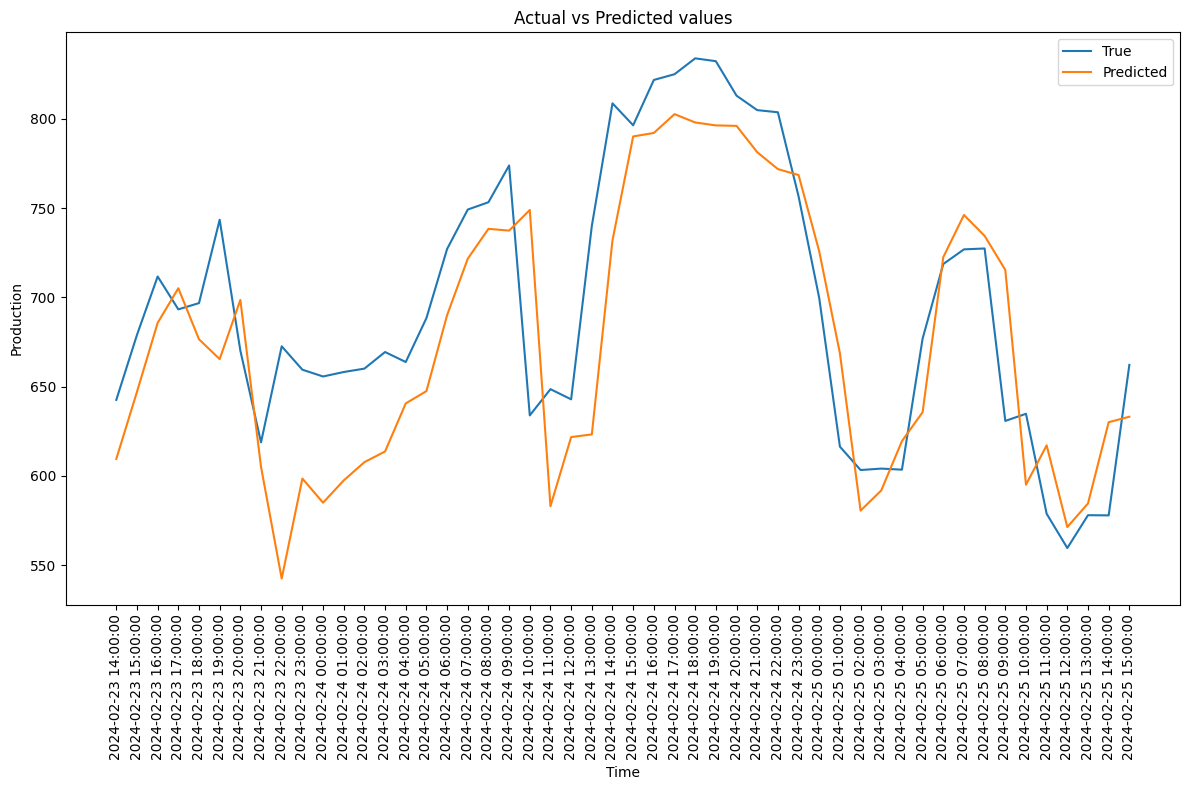

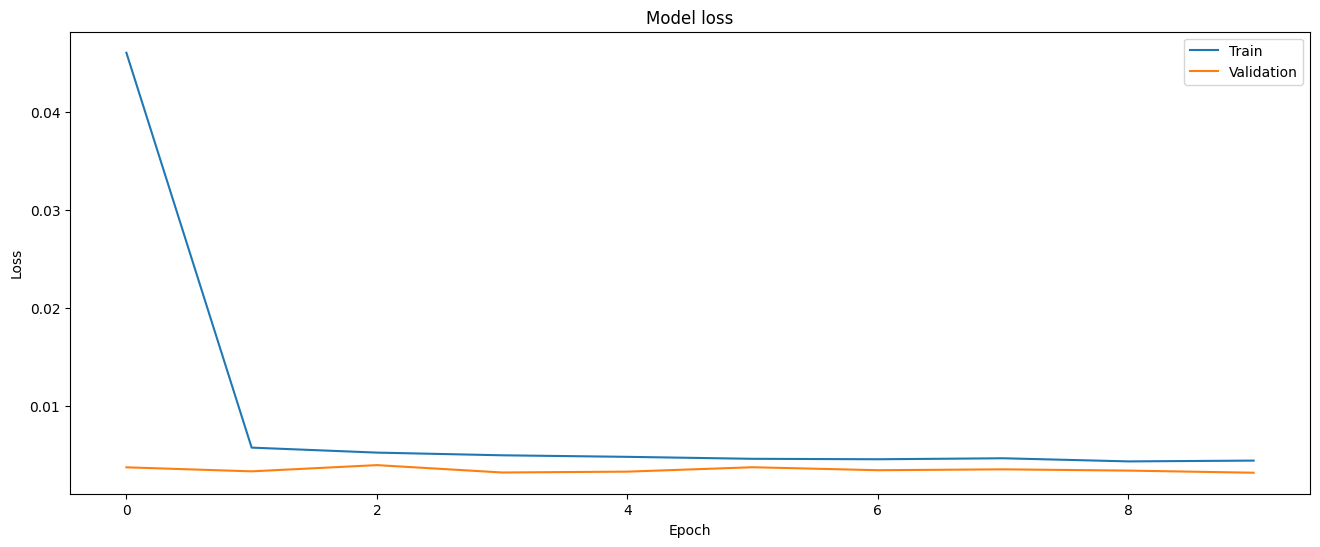

         Feature  Information_Gain
0    temperature          0.528493
1    cloud_cover          0.089395
2       humidity          0.063318
3     wind_speed          0.056205
4  precipitation          0.006531
   production  temperature  cloud_cover  humidity
0       698.5          6.9           53        91
1       698.5          6.9           32        92
2       698.5          8.1            8        89
3       698.4          7.6            6        91
4       698.4          7.3           24        92
Train data shape: (10022, 4)
Test data shape: (2505, 4)
Shape of X_train: (9998, 24, 4)
Shape of X_test: (2481, 24, 4)
Shape of y_train: (9998,)
Shape of y_test: (2481,)
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0830 - val_loss: 0.0034
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 9.4085e-04 - val_loss: 0.0013
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - 

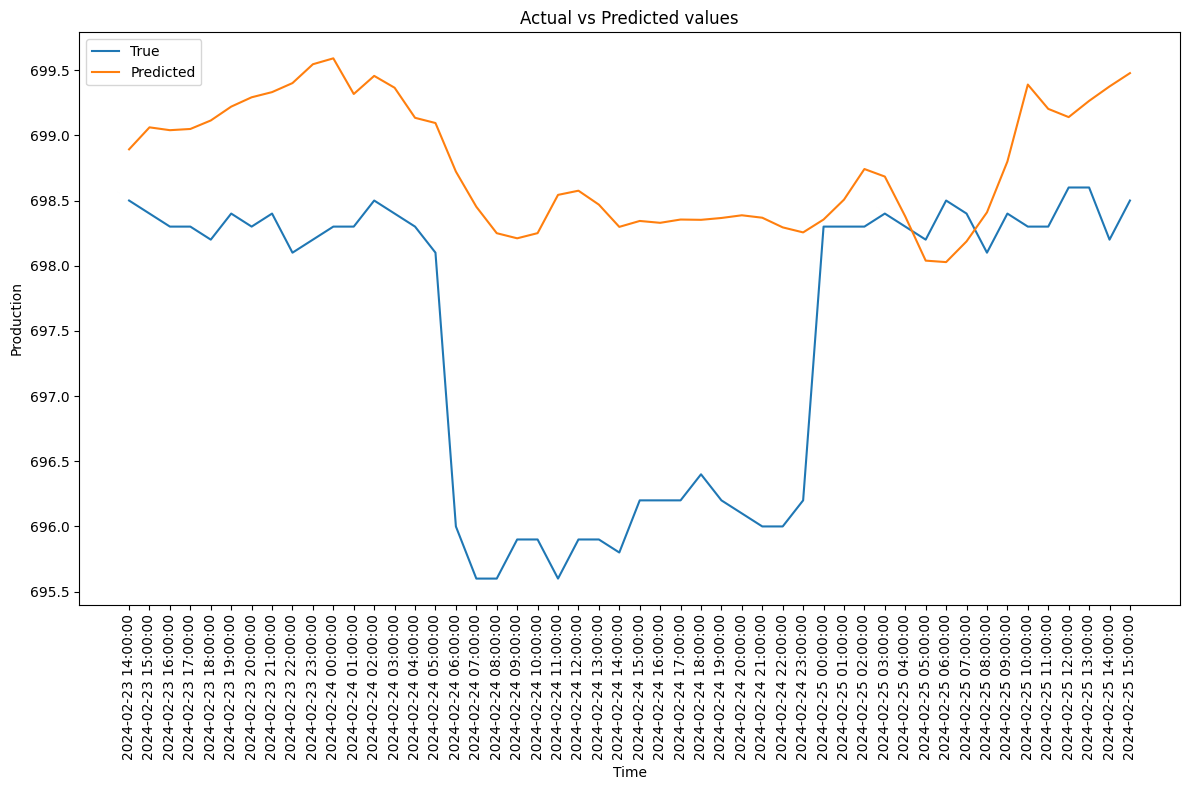

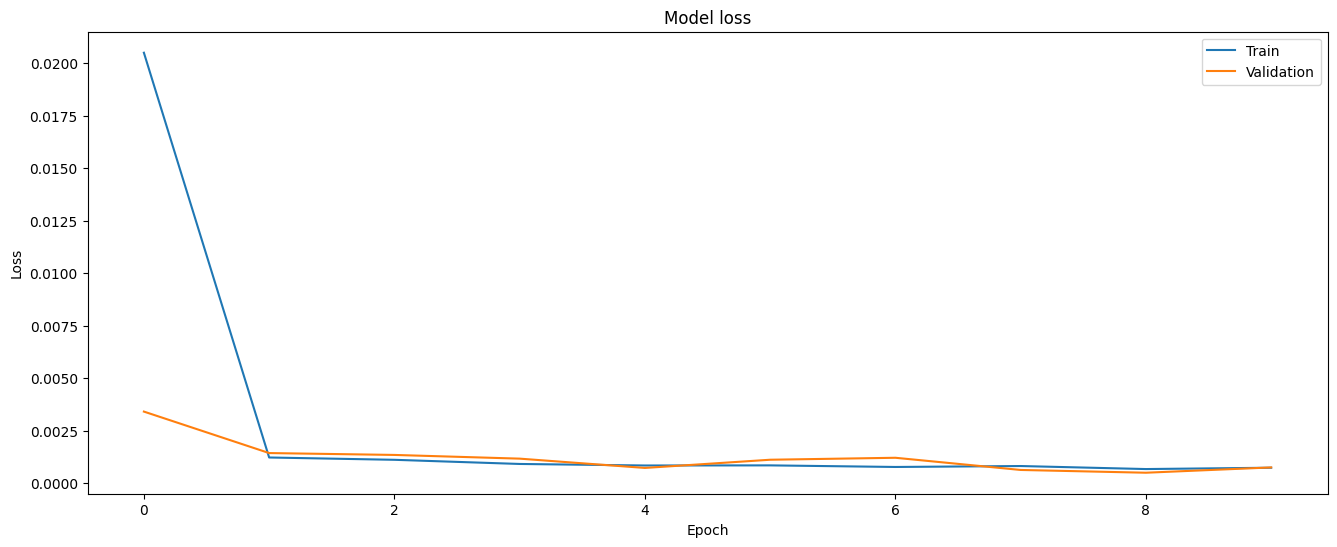

In [46]:
for df in dfs:
    input_data, output_data = select_input_data(df)
    feature_scores = mutual_regression_score(df, input_data, output_data)
    dataset, input_columns = select_features(output_data, feature_scores)
    train_data, test_data, test_data_size = shape_data(dataset)
    pred, actual, hist = execute_training(train_data, test_data, input_columns)
    evaluate_model_performance(actual, pred, test_data_size, hist)